In [1]:
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.run import run_jaqal_circuit
from jaqalpaq.core.result import parse_jaqal_output_list

## A Familiar Circuit

In [2]:
jaqal_circuit = parse_jaqal_string("""
from qscout.v1.std usepulses *

register q[2]

let pi2 1.5707963267948966
let pi4 0.7853981633974483

macro hadamard target { // A Hadamard gate can be implemented as
    Sy target           // a pi/2 rotation around Y
    Px target           // followed by a pi rotation around X.
}
macro cnot control target {  // CNOT implementation from Maslov (2017)
    Sy control
    MS control target 0 pi2
    <Sxd control | Sxd target>  // we can perform these in parallel
    Syd control
}

prepare_all
 hadamard q[0]
 cnot q[0] q[1]
measure_all

loop 10 {
 prepare_all
 hadamard q[0]
 cnot q[0] q[1]
 Px q[0]
 measure_all
}

""")

## Unitary Emulation

In [3]:
jaqal_result = run_jaqal_circuit(jaqal_circuit)

In [4]:
jaqal_result

In [5]:
jaqal_result.readouts

[<Readout 11 index 0 from 0>,
 <Readout 01 index 1 from 1>,
 <Readout 01 index 2 from 1>,
 <Readout 01 index 3 from 1>,
 <Readout 10 index 4 from 1>,
 <Readout 01 index 5 from 1>,
 <Readout 10 index 6 from 1>,
 <Readout 01 index 7 from 1>,
 <Readout 01 index 8 from 1>,
 <Readout 10 index 9 from 1>,
 <Readout 01 index 10 from 1>]

In [6]:
jaqal_result.readouts[1].as_int, jaqal_result.readouts[1].as_str

(2, '01')

In [7]:
jaqal_result.subcircuits

[<EmulatorSubcircuit 0@[7]>, <EmulatorSubcircuit 1@[8, 8]>]

In [8]:
jaqal_result.subcircuits[1].readouts

[<Readout 01 index 1 from 1>,
 <Readout 01 index 2 from 1>,
 <Readout 01 index 3 from 1>,
 <Readout 10 index 4 from 1>,
 <Readout 01 index 5 from 1>,
 <Readout 10 index 6 from 1>,
 <Readout 01 index 7 from 1>,
 <Readout 01 index 8 from 1>,
 <Readout 10 index 9 from 1>,
 <Readout 01 index 10 from 1>]

In [9]:
jaqal_result.subcircuits[1].probability_by_int

array([7.08490623e-33, 5.00000000e-01, 5.00000000e-01, 8.03767555e-33])

In [10]:
print('\n'.join([r.as_str for r in jaqal_result.readouts]))

11
01
01
01
10
01
10
01
01
10
01


In [11]:
data_from_qscout = """00
01
01
01
01
01
01
01
01
01
01"""
qscout_result = parse_jaqal_output_list(jaqal_circuit, data_from_qscout.split("\n"))
qscout_result.readouts

[<Readout 00 index 0 from 0>,
 <Readout 01 index 1 from 1>,
 <Readout 01 index 2 from 1>,
 <Readout 01 index 3 from 1>,
 <Readout 01 index 4 from 1>,
 <Readout 01 index 5 from 1>,
 <Readout 01 index 6 from 1>,
 <Readout 01 index 7 from 1>,
 <Readout 01 index 8 from 1>,
 <Readout 01 index 9 from 1>,
 <Readout 01 index 10 from 1>]

## Processing the Results

In [12]:
import matplotlib
from matplotlib import pyplot
from numpy import bincount

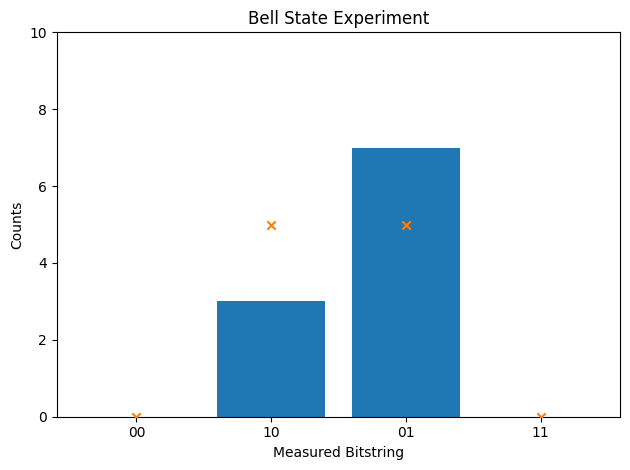

In [13]:
fig, ax = pyplot.subplots()
ax.set(ylim=(0,10))
data = [r.as_int for r in jaqal_result.subcircuits[1].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[1].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 10, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
fig.tight_layout()
pyplot.show()

## Noisy Density Matrix Simulation

In [14]:
from qscout.v1.std.noisy import SNLToy1

In [15]:
jaqal_result = run_jaqal_circuit(jaqal_circuit, backend=SNLToy1(2, depolarization=2e-3))

In [16]:
jaqal_result

In [17]:
jaqal_result.subcircuits[1].probability_by_int

array([0.01231296, 0.48720558, 0.48672233, 0.01375913])

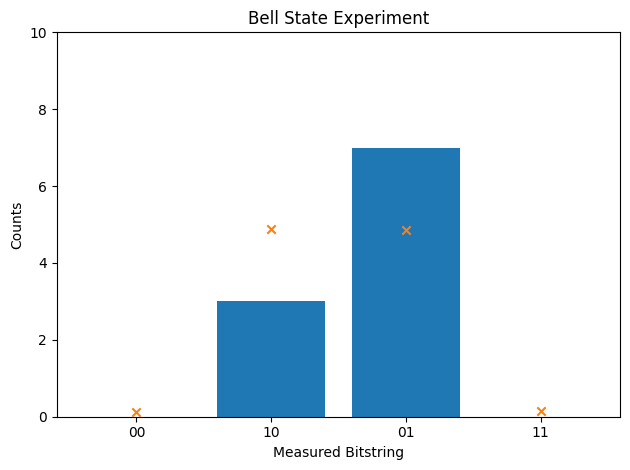

In [18]:
fig, ax = pyplot.subplots()
ax.set(ylim=(0,10))
data = [r.as_int for r in jaqal_result.subcircuits[1].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[1].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 10, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
fig.tight_layout()
pyplot.show()

## What is this object though?

In [19]:
con_model = SNLToy1(2, depolarization=2e-3)

In [20]:
con_model.__dict__.keys()

dict_keys(['depolarization', 'rotation_error', 'phase_error', 'n_qubits', 'stretched_gates', 'model', 'gate_durations'])

Parameters:

In [21]:
con_model.depolarization, con_model.rotation_error, con_model.phase_error

(0.002, 0.01, 0.01)

A process matrix for every gate:

In [22]:
con_model.model

A duration for every gate:

In [23]:
con_model.gate_durations

{'R': <bound method SNLToy1.gateduration_R of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'MS': <bound method SNLToy1.gateduration_MS of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'Rz': <bound method SNLToy1.gateduration_Rz of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'Rx': <bound method ExtensibleBackend._curry.<locals>._inner.<locals>.newop of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'Ry': <bound method ExtensibleBackend._curry.<locals>._inner.<locals>.newop of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'Px': <bound method ExtensibleBackend._curry.<locals>._inner.<locals>.newop of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'Py': <bound method ExtensibleBackend._curry.<locals>._inner.<locals>.newop of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 'Pz': <bound method ExtensibleBackend._curry.<locals>._inner.<locals>.newop of <qscout.v1.std.noisy.SNLToy1 object at 0x85aa69c9ca30>>,
 '

The model and gate durations are all we actually need.

You can manually assemble them into with `CircuitEmulator`:

In [24]:
from jaqalpaq.emulator.pygsti import CircuitEmulator

backend = CircuitEmulator(model=con_model.model, gate_durations=con_model.gate_durations)

In [25]:
jaqal_result = run_jaqal_circuit(jaqal_circuit, backend=backend)

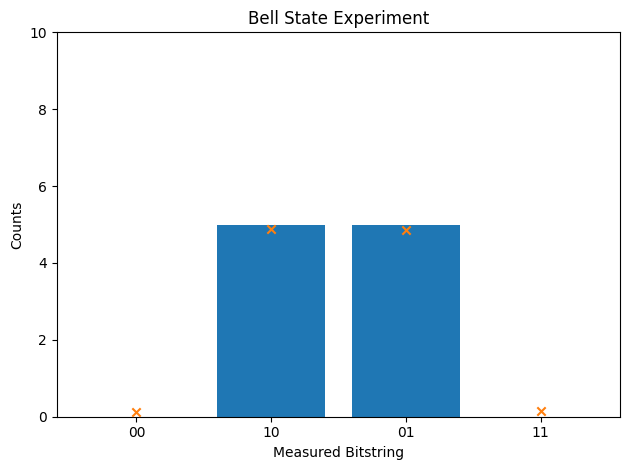

In [26]:
fig, ax = pyplot.subplots()
ax.set(ylim=(0,10))
data = [r.as_int for r in jaqal_result.subcircuits[1].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[1].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 10, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
fig.tight_layout()
pyplot.show()

## I want to make my own error model!

(Let's ignore crosstalk for now.)

You need:
 - A process matrix for every gate
 - A process matrix describing a qubit that is not being driven
 - The duration of the gates
 
 You could do this by hand, but we have a helper class to make this a little easier:

In [27]:
# Useful tools:
from numpy import abs, diag, pi, kron
import pygsti

# Description of the ideal gates
from qscout.v1.std.jaqal_gates import U_R, U_Rz, U_MS

# This superclass will handle some details
from jaqalpaq.emulator.pygsti import AbstractNoisyNativeEmulator

# The superclass needs a description of the gates to handle
from qscout.v1.std.jaqal_gates import ALL_GATES


class MyToyEmulator(AbstractNoisyNativeEmulator):
    # This tells AbstractNoisyNativeEmulator what gate set we're modeling:
    jaqal_gates = ALL_GATES

    def __init__(self, *args, **kwargs):
        """Builds a MyCustomEmulator instance for particular parameters

        :param depolarization float: (default 1e-3) The depolarization during one
          pi/2 gate.
        :param rotation_error float: (default 1e-2) The over-rotation angle during one
          pi/2 gate.
        :param phase_error: (default 1e-2) The error in the x-y angle for (non-Z)
          rotation gates.
        """
        
        # Equivalent to
        # self.depolarization = kwargs.pop('depolarization', 1e-3 )
        # ...
        self.set_defaults(
            kwargs, depolarization=1e-3, rotation_error=1e-2, phase_error=1e-2
        )
        
        # Pass through the balance of the parameters to AbstractNoisyNativeEmulator
        # In particular: passes the number of qubits to emulated (in args)
        super().__init__(*args, **kwargs)

    # For every gate, we need to specify a superoperator and a duration:
    
    # pyGSTi has gate names that start with capital G
    # To avoid name clashes, we prepend our gates with J:    
    # GJR
    
    # We DO NOT currently support qubit-dependent error models (q will always be None)
    # Support for this is planned.  In the future, you will be able to write case
    # statements returning different process matrices for different qubits.
    def gateduration_R(self, q, axis_angle, rotation_angle):
        return abs(rotation_angle) / (pi / 2)

    def gate_R(self, q, axis_angle, rotation_angle):
        # We model the decoherence and over-rotation as a function of the gate duration:
        duration = self.gateduration_R(q, axis_angle, rotation_angle)

        # I.e., we scale the rotation and depolarization error by the time
        scaled_rotation_error = self.rotation_error * duration
        depolarization_term = (1 - self.depolarization) ** duration

        # Combine these all, returning a superoperator in the Pauli basis
        return pygsti.unitary_to_pauligate(
            U_R(axis_angle + self.phase_error, rotation_angle + scaled_rotation_error)
        ) @ diag([1, depolarization_term, depolarization_term, depolarization_term])

    # GJMS
    def gateduration_MS(self, q0, q1, axis_angle, rotation_angle):
        # Assume MS pi/2 gate 10 times longer than Sx, Sy, Sz
        return 10 * abs(rotation_angle) / (pi / 2)

    def gate_MS(self, q0, q1, axis_angle, rotation_angle):
        duration = self.gateduration_MS(q0, q1, axis_angle, rotation_angle)

        scaled_rotation_error = self.rotation_error * duration
        depolarization_term = (1 - self.depolarization) ** duration

        return pygsti.unitary_to_pauligate(
            U_MS(axis_angle + self.phase_error, rotation_angle + scaled_rotation_error)
        ) @ kron(diag([1] + 3*[depolarization_term]), diag([1] + 3*[depolarization_term]))

    
    # Rz is performed entirely in software.
    # GJRz
    def gateduration_Rz(self, q, angle):
        return 0

    def gate_Rz(self, q, angle):
        return pygsti.unitary_to_pauligate(U_Rz(angle))

    # A process matrix for the idle behavior of a qubit.
    # Gidle
    def idle(self, q, duration):
        depolarization_term = (1 - self.depolarization) ** duration

        return diag([1, depolarization_term, depolarization_term, depolarization_term])

    
    # We'll model the Rx gate as just an R gate with a particular axis_angle:
    
    # GJRx
    def gateduration_Rx(self, q, rotation_angle):
        # return self.gateduration_R(q, 0, rotation_angle)
        return abs(rotation_angle) / (pi / 2)

    def gate_Rx(self, q, rotation_angle):
        # return self.gate_R(q, 0, rotation_angle)
        duration = self.gateduration_Rx(q, rotation_angle)

        scaled_rotation_error = self.rotation_error * duration
        depolarization_term = (1 - self.depolarization) ** duration

        return pygsti.unitary_to_pauligate(
            U_R(0 + self.phase_error, rotation_angle + scaled_rotation_error)
        ) @ diag([1, depolarization_term, depolarization_term, depolarization_term])
    
    
    # We could do this for all the other gates, but that would be tedious.
    # Instead, we'll fill in the parameters with some syntactic sugar:

    # Instead of copy-pasting the above definitions, use _curry to create new methods
    # with some arguments.  None is a special argument that means: require an argument
    # in the created function and pass it through.
    C = AbstractNoisyNativeEmulator._curry

    # For reference:
    # def gate_R(self, q, axis_angle, rotation_angle):
    
    # GJRy ... etc
    gateduration_Ry, gate_Ry = C((None, pi / 2, None), gateduration_R, gate_R)
    gateduration_Px, gate_Px = C((None, 0.0, pi), gateduration_R, gate_R)
    gateduration_Py, gate_Py = C((None, pi / 2, pi), gateduration_R, gate_R)
    gateduration_Pz, gate_Pz = C((None, pi), gateduration_Rz, gate_Rz)
    gateduration_Sx, gate_Sx = C((None, 0.0, pi / 2), gateduration_R, gate_R)
    gateduration_Sy, gate_Sy = C((None, pi / 2, pi / 2), gateduration_R, gate_R)
    gateduration_Sz, gate_Sz = C((None, pi / 2), gateduration_Rz, gate_Rz)
    gateduration_Sxd, gate_Sxd = C((None, 0.0, -pi / 2), gateduration_R, gate_R)
    gateduration_Syd, gate_Syd = C((None, pi / 2, -pi / 2), gateduration_R, gate_R)
    gateduration_Szd, gate_Szd = C((None, -pi / 2), gateduration_Rz, gate_Rz)
    gateduration_Sxx, gate_Sxx = C((None, None, 0.0, pi / 2), gateduration_MS, gate_MS)

    del C

In [28]:
backend = MyToyEmulator(2)

In [29]:
jaqal_result = run_jaqal_circuit(jaqal_circuit, backend=backend)

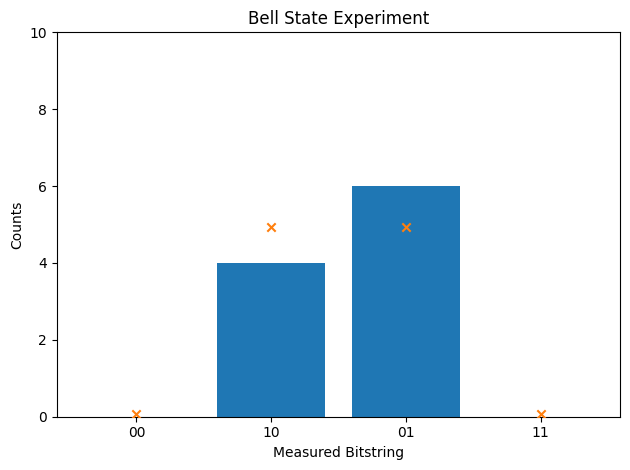

In [30]:
fig, ax = pyplot.subplots()
ax.set(ylim=(0,10))
data = [r.as_int for r in jaqal_result.subcircuits[1].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[1].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 10, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
fig.tight_layout()
pyplot.show()

The minimal skeleton to use `AbstractNoisyNativeEmulator`

In [31]:
from qscout.v1.std.jaqal_gates import ALL_GATES
from jaqalpaq.emulator.pygsti import AbstractNoisyNativeEmulator

class YourCustomEmulator(AbstractNoisyNativeEmulator):
    jaqal_gates = ALL_GATES

    def __init__(self, *args, **kwargs):
        self.set_defaults(
            kwargs, #your custom parameters
        )
        super().__init__(*args, **kwargs)

    # GJR
    def gateduration_R(self, q, axis_angle, rotation_angle):
        return # your model's duration

    def gate_R(self, q, axis_angle, rotation_angle):
        return # your error model's superoperator in the Pauli basis
    
    # Gidle
    def idle(self, q, duration):
        return # your model's process matrix acting for the idle qubit
    
    # the rest of the gates